In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df= pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv')

In [3]:
df1=df[(df['ocean_proximity']=='<1H OCEAN') | (df['ocean_proximity']=='INLAND')]

df1 = df1.reset_index(drop=True)

In [4]:
df1.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        157
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [5]:
df1.fillna(value=0, inplace=True)

In [6]:
df1.isna().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

In [7]:
df1['median_house_value'] = np.log1p(df1['median_house_value'])

In [8]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df1, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.median_house_value.values
y_val = df_val.median_house_value.values
y_test = df_test.median_house_value.values

del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

In [9]:
from sklearn.feature_extraction import DictVectorizer
dv = DictVectorizer(sparse=True)

train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

### Question 1

In [10]:
from sklearn.tree import DecisionTreeRegressor, export_text

In [11]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [12]:
print(export_text(dt, feature_names=list(dv.get_feature_names_out())))

|--- ocean_proximity=<1H OCEAN <= 0.50
|   |--- value: [11.61]
|--- ocean_proximity=<1H OCEAN >  0.50
|   |--- value: [12.30]



Answer: ocean_proximity

### Question 2

In [13]:
from sklearn.ensemble import RandomForestRegressor

In [14]:
rfr = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rfr.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [15]:
from sklearn.metrics import mean_squared_error
y_pred = rfr.predict(X_val)
rmse = mean_squared_error(y_val, y_pred, squared=False)
round(rmse,3)

0.245

Answer: 0.245

### Question 3

In [16]:
scores = []
for n in range(10, 201, 10):
    rfr = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rfr.fit(X_train, y_train)
    y_pred = rfr.predict(X_val)
    rmse = round(mean_squared_error(y_val, y_pred, squared=False),3)
    scores.append((n, rmse))

df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])

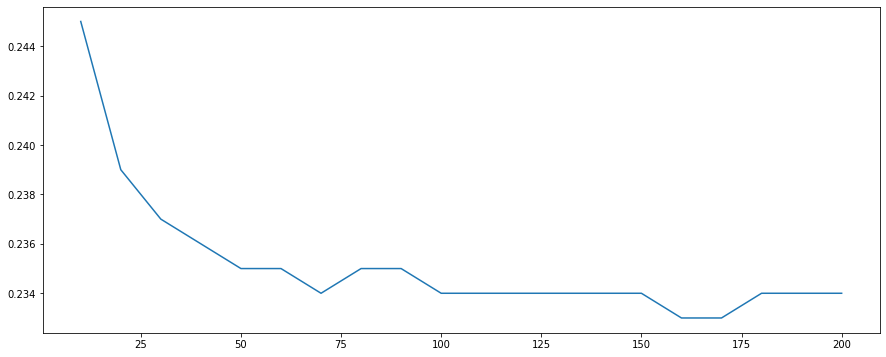

In [17]:
plt.figure(figsize=(15,6))
plt.plot(df_scores.n_estimators, df_scores.rmse)

In [18]:
df_scores[df_scores['rmse']==df_scores['rmse'].min()]

,n_estimators,rmse
15,160,0.233
16,170,0.233


In [19]:
df_scores[12:]

,n_estimators,rmse
12,130,0.234
13,140,0.234
14,150,0.234
15,160,0.233
16,170,0.233
17,180,0.234
18,190,0.234
19,200,0.234


Answer: 160

### Question 4

In [20]:
scores = []

for d in [10, 15, 20, 25]:
    for n in range(10, 201, 10):
        rfr = RandomForestRegressor(n_estimators=n, max_depth=d, random_state=1, n_jobs=-1)
        rfr.fit(X_train, y_train)
        y_pred = rfr.predict(X_val)
        rmse = round(mean_squared_error(y_val, y_pred, squared=False),3)
        scores.append((d, n, rmse))

In [21]:
columns = ['max_depth', 'n_estimators', 'rmse']
df_scores = pd.DataFrame(scores, columns=columns)

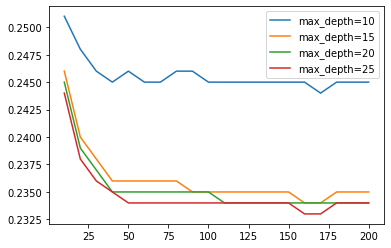

In [22]:
for d in [10, 15, 20, 25]:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.rmse,
             label='max_depth=%d' % d)

plt.legend()

In [23]:
for d in [10, 15, 20, 25]:
    df_subset = df_scores[df_scores.max_depth == d]
    mean_rmse= df_subset.rmse.mean()
    print(f"max_depth: {d}, mean_rmse : {mean_rmse}")

max_depth: 10, mean_rmse : 0.24559999999999998
max_depth: 15, mean_rmse : 0.23610000000000006
max_depth: 20, mean_rmse : 0.23529999999999998
max_depth: 25, mean_rmse : 0.23475000000000001


Answer: max_depth= 25

### Question 5

In [24]:
rfr = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
rfr.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [25]:
feature_importance = rfr.feature_importances_
feature_list = list(dv.get_feature_names_out())
order_feat=sorted(zip(feature_importance, feature_list), reverse=True)
order_feat

[(0.33561112799548903, 'median_income'),
 (0.29247296545343093, 'ocean_proximity=<1H OCEAN'),
 (0.10200703165624685, 'latitude'),
 (0.08624381391950157, 'longitude'),
 (0.07380644294558006, 'ocean_proximity=INLAND'),
 (0.030317256108796153, 'housing_median_age'),
 (0.027136059019747173, 'population'),
 (0.021416985559250513, 'total_rooms'),
 (0.015852218895139155, 'total_bedrooms'),
 (0.01513609844681855, 'households')]

Answer: median_income

### Question 6

In [26]:
features = dv.get_feature_names_out()
features

array(['households', 'housing_median_age', 'latitude', 'longitude',
       'median_income', 'ocean_proximity=<1H OCEAN',
       'ocean_proximity=INLAND', 'population', 'total_bedrooms',
       'total_rooms'], dtype=object)

In [27]:
features = ['households', 'housing_median_age', 'latitude', 'longitude',
       'median_income', 'ocean_proximity_1H_OCEAN',
       'ocean_proximity_INLAND', 'population', 'total_bedrooms',
       'total_rooms']

In [28]:
import xgboost as xgb
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [29]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [30]:
for e in [0.1, 0.3]:
    xgb_params = {
        'eta': e, 
        'max_depth': 6,
        'min_child_weight': 1,

        'objective': 'reg:squarederror',
        'nthread': 8,

        'seed': 1,
        'verbosity': 1,
    }

    model = xgb.train(xgb_params, dtrain, num_boost_round=100,verbose_eval=10, evals=watchlist)
    y_pred = model.predict(dval)
    rmse = round(mean_squared_error(y_val, y_pred, squared=False),3)
    print(f"eta: {e}, rmse : {rmse}")

[0]	train-rmse:10.37456	val-rmse:10.37544
[10]	train-rmse:3.63299	val-rmse:3.62939
[20]	train-rmse:1.29412	val-rmse:1.29329
[30]	train-rmse:0.50217	val-rmse:0.51148
[40]	train-rmse:0.26743	val-rmse:0.29345
[50]	train-rmse:0.21121	val-rmse:0.24925
[60]	train-rmse:0.19692	val-rmse:0.24081
[70]	train-rmse:0.18715	val-rmse:0.23708
[80]	train-rmse:0.17941	val-rmse:0.23424
[90]	train-rmse:0.17320	val-rmse:0.23231
[99]	train-rmse:0.16845	val-rmse:0.23052
eta: 0.1, rmse : 0.231
[0]	train-rmse:8.07362	val-rmse:8.07348
[10]	train-rmse:0.33195	val-rmse:0.34802
[20]	train-rmse:0.20036	val-rmse:0.24508
[30]	train-rmse:0.18204	val-rmse:0.23833
[40]	train-rmse:0.16422	val-rmse:0.23379
[50]	train-rmse:0.15210	val-rmse:0.23262
[60]	train-rmse:0.14218	val-rmse:0.23160
[70]	train-rmse:0.13471	val-rmse:0.23108
[80]	train-rmse:0.12835	val-rmse:0.23045
[90]	train-rmse:0.12174	val-rmse:0.22957
[99]	train-rmse:0.11656	val-rmse:0.22897
eta: 0.3, rmse : 0.229


Answer: eta=0.3 has the best RMSE score on the validation dataset